In [19]:
import os  # 导入操作系统模块
import math  # 导入数学模块
import torch  # 导入PyTorch深度学习框架
import torch.nn as nn  # 导入PyTorch的神经网络模块
import random  # 导入随机数模块
import numpy as np  # 导入NumPy科学计算库
from matplotlib import pyplot as plt  # 导入matplotlib绘图库
from torch.autograd import Variable  # 导入PyTorch的自动微分模块
from torchvision import datasets  # 导入PyTorch视觉工具包中的数据集模块
from torchvision.transforms import ToTensor  # 导入PyTorch视觉工具包中的张量转换模块
from torch import optim  # 导入PyTorch优化器模块
import time  # 导入时间模块
from botorch.models import SingleTaskGP  # 导入BoTorch单任务高斯过程模型
from gpytorch.mlls import ExactMarginalLogLikelihood  # 导入GPyTorch精确边际对数似然模块
from botorch.fit import fit_gpytorch_mll  # 导入BoTorch拟合GPyTorch精确边际对数似然模块
from botorch.sampling.normal import SobolQMCNormalSampler  # 导入BoTorch Sobol QMC正态采样器模块
from botorch.acquisition import qExpectedImprovement, qKnowledgeGradient  # 导入BoTorch采集函数模块
from botorch.optim import optimize_acqf  # 导入BoTorch优化采集函数模块

# 设置种子以确保可重复性
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 如果GPU可用，则使用GPU，否则使用CPU
dtype = torch.double  # 设置张量类型为双精度

import warnings  # 导入警告模块
warnings.filterwarnings("ignore", category=Warning)  # 忽略警告信息

# 加载MNIST数据集
train_data = datasets.MNIST(root='data', train=True, transform=ToTensor(), download=True)  # 加载训练数据集
test_data = datasets.MNIST(root='data', train=False, transform=ToTensor())  # 加载测试数据集

# 为训练准备数据加载器
from torch.utils.data import DataLoader  # 导入数据加载器模块
loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True),  # 训练数据加载器60000
    'test': DataLoader(test_data, batch_size=100, shuffle=True)  # 测试数据加载器10000
}

In [20]:
# 定义带有可学习参数 sigma 的 GELU 激活函数
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1))  # 可学习参数 sigma

    def forward(self, x):
        return x * (1 + torch.erf(x / math.sqrt(2) / self.sigma)) / 2

# 定义一个简单的全连接网络模型，使用 GELU 激活函数
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(784, 20)
        self.linear2 = nn.Linear(20, 20)
        self.linear3 = nn.Linear(20, 10)
        self.gelu1 = GELU()
        self.gelu2 = GELU()
    
    def forward(self, X):
        X = X.view(-1, 28 * 28)  # 将输入重新调整形状以匹配 linear1 的输入尺寸
        X = self.gelu1(self.linear1(X))
        X = self.gelu2(self.linear2(X))
        X = self.linear3(X)
        return X

# 定义用于 CNN 的训练和测试函数
class CNN_CLASSIFIER(nn.Module):
    def __init__(self, loaders, num_epochs=10, verbose_train=False, verbose_test=False):
        super(CNN_CLASSIFIER, self).__init__()
        self.loaders = loaders
        self.num_epochs = num_epochs
        self.model = SimpleNN().to(device)
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.verbose_train = verbose_train
        self.verbose_test = verbose_test

    def forward(self, sigma_values, learning_rate):
        self.model.gelu1.sigma.data.fill_(sigma_values[0])  # 设置第一个 GELU 层的 sigma
        self.model.gelu2.sigma.data.fill_(sigma_values[1])  # 设置第二个 GELU 层的 sigma
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)  # 使用 SGD 优化器
        for t in range(self.num_epochs):
            self.train(verbose=self.verbose_train)  # 训练模型
            test_accuracy = self.test(verbose=self.verbose_test)  # 测试模型准确率
        return test_accuracy

    def train(self, verbose=False):
        self.model.train()  # 设置模型为训练模式
        total_img = len(self.loaders['train'].dataset)  # 获取训练集总图像数
        for batch, (X, y) in enumerate(self.loaders['train']):
            X, y = X.to(device), y.to(device)
            pred = self.model(X)  # 前向传播
            loss = self.criterion(pred, y)  # 计算损失
            self.optimizer.zero_grad()  # 梯度清零
            loss.backward()  # 反向传播
            self.optimizer.step()  # 更新权重
            if verbose and batch % 100 == 0:
                loss, current_img_idx = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current_img_idx:>5d}/{total_img:>5d}]")  # 打印损失信息
        return self

    def test(self, verbose=False):
        self.model.eval()  # 设置模型为评估模式
        total_img = len(self.loaders['test'].dataset)  # 获取测试集总图像数
        correct = 0
        with torch.no_grad():
            for X, y in self.loaders['test']:
                X, y = X.to(device), y.to(device)
                pred = self.model(X)  # 前向传播
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # 计算正确预测的数量
        correct /= total_img  # 计算准确率
        if verbose:
            print(f"Test accuracy: {correct:>0.3f}")  # 打印测试准确率
        return correct

In [21]:
# 生成初始数据
def generate_initial_data_cnn(n=5):
    # 生成服从均匀分布的初始参数
    train_x = torch.distributions.uniform.Uniform(0.0001, 10).sample([n, 2]).type(torch.DoubleTensor).to(device)
    # 生成学习率的初始参数
    learning_rates = torch.distributions.uniform.Uniform(0.001, 1).sample([n, 1]).type(torch.DoubleTensor).to(device)
    # 将学习率和参数合并
    train_x = torch.cat((train_x, learning_rates), dim=1)
    train_y = []
    for tmp_x in train_x:
        print(f"\n当前的 sigmas 和学习率: {tmp_x.cpu().numpy()}")
        # 初始化 CNN_CLASSIFIER 模型
        nn_classifier = CNN_CLASSIFIER(loaders=loaders, num_epochs=3, verbose_test=True)
        # 使用模型进行训练和测试
        tmp_y = nn_classifier(sigma_values=tmp_x[:-1].cpu().numpy(), learning_rate=tmp_x[-1].cpu().numpy())
        train_y.append(tmp_y)
    # 将训练结果转换为张量
    train_y = torch.tensor([[tmp] for tmp in train_y]).type(torch.DoubleTensor).to(device)
    # 计算最佳观测值
    best_observed_value = train_y.max().item()
    return train_x, train_y, best_observed_value

# 初始化 GP 模型
def initialize_model(train_x, train_y):
    # 初始化单任务 GP 模型
    model = SingleTaskGP(train_x, train_y)
    # 初始化边际对数似然函数
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

# 优化采集函数并获取观测结果
def optimize_acqf_and_get_observation_cnn(acq_func, sigma_values_list, learning_rates_list, accuracies_list):
    # 定义参数边界
    bounds = torch.tensor([[0.0001, 0.0001, 0.001], [10.0, 10.0, 1.0]], device=device, dtype=dtype)
    BATCH_SIZE = 5
    NUM_RESTARTS = 10
    RAW_SAMPLES = 1024

    # 优化采集函数
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        options={"batch_limit": 5, "maxiter": 200},
    )

    # 将结果转换为张量并移动到对应设备
    new_x = candidates.detach().to(device)
    new_y = []
    for tmp_x in new_x:
        print(f"\n当前的 sigmas 和学习率: {tmp_x.cpu().numpy()}")
        # 初始化 CNN_CLASSIFIER 模型
        nn_classifier = CNN_CLASSIFIER(loaders=loaders, num_epochs=3, verbose_test=True)
        # 使用模型进行训练和测试
        tmp_y = nn_classifier(sigma_values=tmp_x[:-1].cpu().numpy(), learning_rate=tmp_x[-1].cpu().numpy())
        new_y.append(tmp_y)

        # 记录 sigma 值、学习率和准确率
        sigma_values_list.append(tmp_x[:-1].cpu().numpy())
        learning_rates_list.append(tmp_x[-1].cpu().numpy())
        accuracies_list.append(tmp_y)
        
    # 将结果转换为张量
    new_y = torch.tensor([[tmp] for tmp in new_y]).type(torch.DoubleTensor).to(device)
    return new_x, new_y

In [22]:
# 运行优化循环
N_TRIALS = 5  # 总试验次数
N_BATCH = 5   # 每次试验的批次数

best_observed_all_qei, best_observed_all_qkg = [], []  # 存储每次试验的最佳观测值列表
sigma_values_qei = []  # 存储 qEI 优化过程中的 sigma 值列表
learning_rates_qei = []  # 存储 qEI 优化过程中的学习率列表
accuracies_qei = []  # 存储 qEI 优化过程中的准确率列表
sigma_values_qkg = []  # 存储 qKG 优化过程中的 sigma 值列表
learning_rates_qkg = []  # 存储 qKG 优化过程中的学习率列表
accuracies_qkg = []  # 存储 qKG 优化过程中的准确率列表

for trial in range(1, N_TRIALS + 1):  # 对于每次试验
    best_observed_qei, best_observed_qkg = [], []  # 存储每次试验中的最佳观测值列表
    # 生成初始数据
    train_x_qei, train_y_qei, best_observed_value_qei = generate_initial_data_cnn(n=3)  # 生成 qEI 初始数据
    mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)  # 初始化 qEI GP 模型
    train_x_qkg, train_y_qkg = train_x_qei, train_y_qei  # 使用 qEI 的初始数据作为 qKG 的初始数据
    best_observed_value_qkg = best_observed_value_qei  # 记录 qKG 的最佳观测值
    mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)  # 初始化 qKG GP 模型

    best_observed_qei.append(best_observed_value_qei)  # 记录 qEI 的最佳观测值
    best_observed_qkg.append(best_observed_value_qkg)  # 记录 qKG 的最佳观测值

    t0_total = time.monotonic()  # 开始计时
    
    for iteration in range(1, N_BATCH + 1):  # 对于每个批次
        t0 = time.monotonic()  # 开始计时
        # 优化 GP 模型
        fit_gpytorch_mll(mll_qei.cpu())
        mll_qei = mll_qei.to(device)
        model_qei = model_qei.to(device)

        fit_gpytorch_mll(mll_qkg.cpu())
        mll_qkg = mll_qkg.to(device)
        model_qkg = model_qkg.to(device)

        # 定义采集函数
        qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
        qEI = qExpectedImprovement(model=model_qei, best_f=train_y.max(), sampler=qmc_sampler)
        qKG = qKnowledgeGradient(model=model_qkg, num_fantasies=MC_SAMPLES)

        # 优化采集函数并获取观测结果
        new_x_qei, new_y_qei = optimize_acqf_and_get_observation_cnn(qEI, sigma_values_qei, learning_rates_qei, accuracies_qei)
        new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation_cnn(qKG, sigma_values_qkg, learning_rates_qkg, accuracies_qkg)

        # 更新训练数据
        train_x_qei = torch.cat([train_x_qei, new_x_qei])
        train_y_qei = torch.cat([train_y_qei, new_y_qei])
        train_x_qkg = torch.cat([train_x_qkg, new_x_qkg])
        train_y_qkg = torch.cat([train_y_qkg, new_y_qkg])

        # 计算当前最佳观测值
        best_value_qei = max(best_observed_qei[-1], new_y_qei.max().item())
        best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.max().item())
        best_observed_qei.append(best_value_qei)  # 记录 qEI 的最佳观测值
        best_observed_qkg.append(best_value_qkg)  # 记录 qKG 的最佳观测值

        # 初始化 GP 模型
        mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
        mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

        t1 = time.monotonic()  # 结束计时
        print(f"\n试验 {trial}/{N_TRIALS},"
            f"\n批次 {iteration:>2}: 最佳观测值 (qEI, qKG) = "
            f"({best_value_qei:>4.2f}, {best_value_qkg:>4.2f}),"
            f"耗时 = {t1 - t0:>4.2f}.", end=""
        )

    best_observed_all_qei.append(best_observed_qei)  # 记录每次试验的 qEI 最佳观测值
    best_observed_all_qkg.append(best_observed_qkg)  # 记录每次试验的 qKG 最佳观测值

    t1_total = time.monotonic()  # 结束计时
    print(f"总耗时 = {t1_total - t0_total:>4.2f}.")


当前的 sigmas 和学习率: [0.28988951 4.01904535 0.05274559]
Test accuracy: 0.887
Test accuracy: 0.916
Test accuracy: 0.923

当前的 sigmas 和学习率: [2.59851575 3.66647673 0.46867108]
Test accuracy: 0.928
Test accuracy: 0.936
Test accuracy: 0.947

当前的 sigmas 和学习率: [0.58310151 7.00647736 0.67413235]
Test accuracy: 0.940
Test accuracy: 0.949
Test accuracy: 0.947

当前的 sigmas 和学习率: [4.55755218 8.58608317 0.14963861]
Test accuracy: 0.904
Test accuracy: 0.926
Test accuracy: 0.936

当前的 sigmas 和学习率: [2.06553883 5.84772626 0.10331133]
Test accuracy: 0.897
Test accuracy: 0.920
Test accuracy: 0.932

当前的 sigmas 和学习率: [0.01776468 2.11831397 0.30796124]
Test accuracy: 0.925
Test accuracy: 0.947
Test accuracy: 0.953

当前的 sigmas 和学习率: [1.13557966 7.30054353 0.49558792]
Test accuracy: 0.926
Test accuracy: 0.945
Test accuracy: 0.944

当前的 sigmas 和学习率: [0.19691535 2.26601726 0.44535727]
Test accuracy: 0.932
Test accuracy: 0.931
Test accuracy: 0.939

当前的 sigmas 和学习率: [4.33962537 6.37052329 0.72881357]
Test accuracy: 0.93

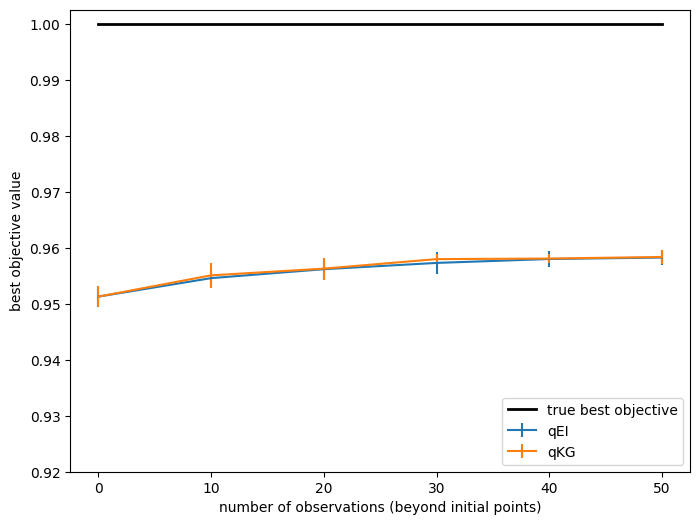

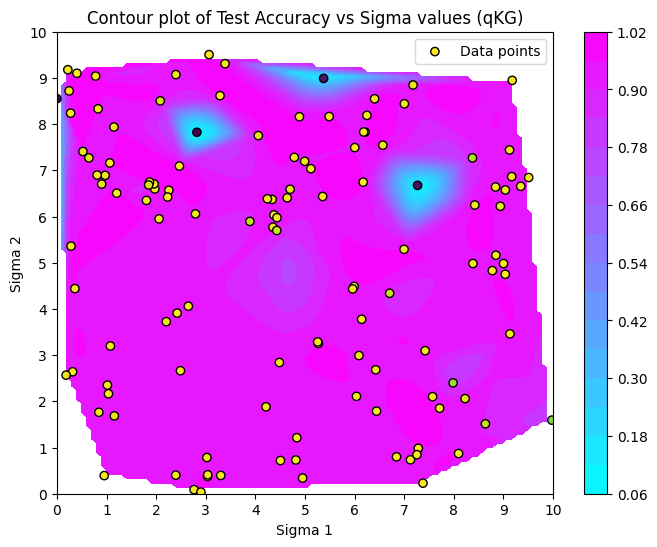

In [46]:
BATCH_SIZE=10

# plot the results
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_all_qei)
y_kg = np.asarray(best_observed_all_qkg)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="qEI", linewidth=1.5)
ax.errorbar(iters, y_kg.mean(axis=0), yerr=ci(y_kg), label="qKG", linewidth=1.5)
plt.plot([0, N_BATCH * BATCH_SIZE], [1] * 2, 'k', label="true best objective", linewidth=2)
ax.set_ylim(bottom=0.92)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
ax.legend(loc="lower right")


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 提取 sigma 和准确率数据
sigma1 = np.array(sigma_values_qkg[:, 0])
sigma2 = np.array(sigma_values_qkg[:, 1])
accuracies = np.array(accuracies_qkg)

# 生成网格数据
grid_x, grid_y = np.meshgrid(np.linspace(sigma1.min(), sigma1.max(), 100),
                             np.linspace(sigma2.min(), sigma2.max(), 100))

# 插值数据到网格上
grid_z = griddata((sigma1, sigma2), accuracies, (grid_x, grid_y), method='cubic')
# 限制等高线图的值域在0到1之间
grid_z = np.clip(grid_z, 0, 1)
# 绘制等高线图
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap('cool')  # 使用 coolwarm 调色方案
contour = plt.contourf(grid_x, grid_y, grid_z, levels=15, cmap=cmap)
plt.colorbar(contour)

# 在图上绘制原始数据点，并使用虚线将其按顺序连接
plt.scatter(sigma1, sigma2, c=accuracies, edgecolors='k', label='Data points')
#plt.plot(sigma1, sigma2, 'k--', label='Path')
# 设置坐标轴范围和刻度
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xticks(np.arange(0, 11, 1))  # x轴每隔1进行标记
plt.yticks(np.arange(0, 11, 1))  # y轴每隔1进行标记

plt.xlabel('Sigma 1')
plt.ylabel('Sigma 2')
plt.title('Contour plot of Test Accuracy vs Sigma values (qKG)')
plt.legend()
plt.show()

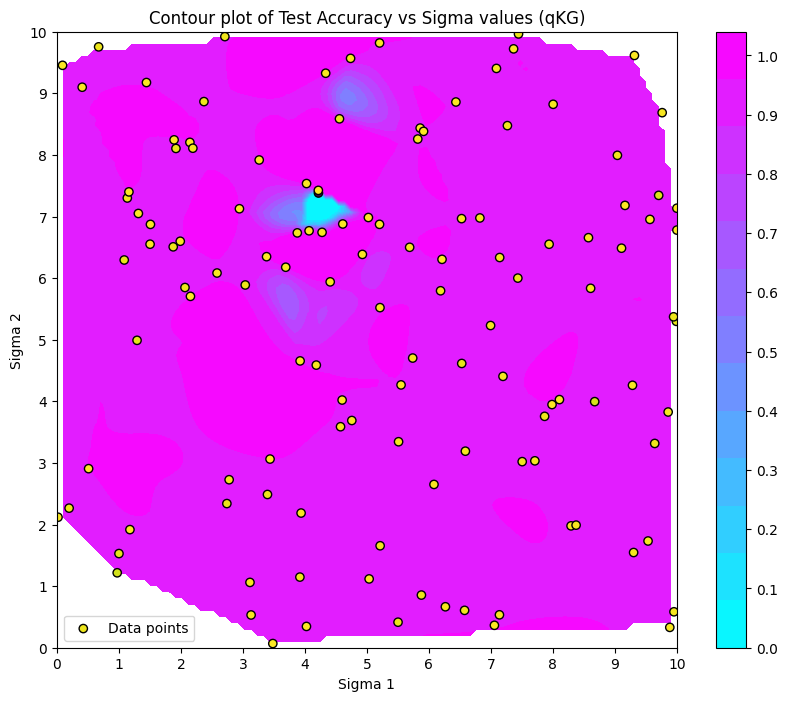

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 提取 sigma 和准确率数据
sigma1 = np.array(sigma_values_qei[:, 0])
sigma2 = np.array(sigma_values_qei[:, 1])
accuracies = np.array(accuracies_qei)

# 生成网格数据，范围为0到10
grid_x, grid_y = np.meshgrid(np.linspace(0, 10, 100),
                             np.linspace(0, 10, 100))

# 插值数据到网格上
grid_z = griddata((sigma1, sigma2), accuracies, (grid_x, grid_y), method='cubic')

# 限制等高线图的值域在0到1之间
grid_z = np.clip(grid_z, 0, 1.04)

# 定义调色方案
cmap = plt.get_cmap('cool')  # 您可以将 'viridis' 替换为其他调色方案

# 绘制等高线图
plt.figure(figsize=(10, 8))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=15, cmap=cmap)
#plt.colorbar(contour)
cbar = plt.colorbar(contour)
cbar.set_ticks(np.linspace(0, 1, 11))  # 设置 colorbar 的刻度范围在0到1之间
# 在图上绘制原始数据点，并使用虚线将其按顺序连接
plt.scatter(sigma1, sigma2, c=accuracies, edgecolors='k', label='Data points')
#plt.plot(sigma1, sigma2, 'k--', label='Path')

# 设置坐标轴范围和刻度
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xticks(np.arange(0, 11, 1))  # x轴每隔1进行标记
plt.yticks(np.arange(0, 11, 1))  # y轴每隔1进行标记

plt.xlabel('Sigma 1')
plt.ylabel('Sigma 2')
plt.title('Contour plot of Test Accuracy vs Sigma values (qKG)')
plt.legend()
plt.show()
